<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     width="30%"
     alt="Dask logo\">

# Dask DataFrames

In [1]:
import pandas as pd

Download the dataset and paste it in this directory:

[UK Housing Prices Paid](https://www.kaggle.com/datasets/hm-land-registry/uk-housing-prices-paid)

In [ ]:
!du -sh price_paid_records.csv

In [3]:
import os


data_file = 'price_paid_records.csv'

## Pandas DataFrames

Very simple uses of `pandas.DataFrame`:

In [6]:
# This may freeze your computer

pdf = pd.read_json(data_file, orient='records', lines=True)

df_len = len(pdf)

max_price = pdf['Price'].max()

mean_price_by_town = pdf.groupby('Town/City')['Price'].mean()

print(df_len)
print(max_price)
print(mean_price_by_town)

## Pandas DataFrames by chunks

In [4]:
from typing import Generator


def read_csv_by_chunks(
    in_file: str, chunksize: int = 50000
) -> Generator[pd.DataFrame, None, None]:
    with pd.read_csv(in_file, chunksize=chunksize) as json_reader:
        for df_chunk in json_reader:
            yield df_chunk
            
            del df_chunk

In [ ]:
df_len = 0
for chunk in read_csv_by_chunks(data_file):
    df_len += len(chunk)

df_len


In [ ]:
chunk.head()

In [ ]:
max_price = 0
for chunk in read_csv_by_chunks(data_file):
    chunk_max_price = chunk['Price'].max()
    if chunk_max_price > max_price:
        max_prize = chunk_max_price
max_price

In [ ]:
town_means = None
for chunk in read_csv_by_chunks(data_file):
    grouped_chunk = chunk.groupby('Town/City')
    group_dict = {
        'price_sum': grouped_chunk["Price"].sum(),
        'price_count': grouped_chunk["Price"].count()
    }
    grouped_df = pd.DataFrame(group_dict)
    if town_means is None:
        town_means = grouped_df
    else:
        town_means = town_means.add(grouped_df, fill_value=0)
        town_means = town_means.combine_first(town_means).combine_first(grouped_df)

town_means['price_sum'] / town_means['price_count']

## Polars LazyFrames

In [9]:
import polars as pl
plf = pl.scan_csv(data_file)

In [ ]:
plf.select(pl.len()).collect().item()

In [ ]:
plf.select(pl.max('Price')).collect().item()

In [ ]:
plf.group_by('Town/City').agg(pl.col('Price').mean().alias('mean_price')).collect()


## Dask DataFrames

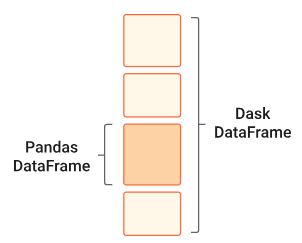

In [13]:
from dask.distributed import LocalCluster, Client

In [ ]:
cluster = LocalCluster(n_workers=4, processes=False)
cluster

We can access the url that the Dask dashboard is being hosted at.

In [ ]:
# Check this page when you run computations with Dask
cluster.dashboard_link

In order for Dask to use our cluster we still need to create a `Client` object, but as we have already created a cluster we can pass that directly to our client.

In [ ]:
client = Client(cluster)
client

In [17]:
import dask.dataframe as dd
ddf = dd.read_csv(data_file)
ddf = ddf.repartition(npartitions=32)

In [ ]:
len_df = ddf.shape[0]
len_df.compute()

In [ ]:
max_price = ddf['Price'].max()
max_price.compute()

In [ ]:
price_mean_by_town = ddf.groupby(['Town/City'])['Price'].mean()
price_mean_by_town.compute()